# The data science pipeline


## Introduction

The data science pipeline refers to a standard series of operations done to data when fitting a statistical model.  It takes as input raw data and produces as output a statistical model from which you can infer something about the system that produced the data.  
This pipeline consists of the following steps, some of which are optional and some of which need to be repeated.  

1. Get raw data
2. Extract features from the data
3. Scale features 
4. Reduce dimensionality
5. Choose hyperparameters of statistical model. 
6. Fit model (estimator) on training data. 
7. Evaluate model on validation data. 
8. Adjust hyperparameter and other modelling choices (steps 2 - 5) based on evaluation. 
9. Evaluate model on test data. 

All of these steps have been implemented in [scikit-learn](http://scikit-learn.org/).  This workbook will give a demonstration of how to set up a pipeline using the sk-learn library.  

I recommend looking at the [tutorials](http://scikit-learn.org/stable/tutorial/index.html), reading the [user guide](http://scikit-learn.org/stable/user_guide.html) and the [API](http://scikit-learn.org/stable/modules/classes.html) for more information. 

A flow chart of how to choose estimators based on your data and requirements is shown below. 

## The problem

The problem we will focus on is that of predicting a number from an 8x8 pixel image of a number. You can read about the data [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) 

We will go through each of the components of the pipeline separately first without worrying about splitting the data into test and training sets.  After that we'll put it all together using the `pipeline` feature and split the data in order to optimize the hyperparameters using grid-search cross-validation. 

### Get data and extract features
The data, called `digits` consist of *features* and *labels*. 

The *features* are pixel intensities (integers 0 - 16) for each of the 64 pixels of the scanned, hand written images. Each row of the *features* matrix is a single image, each column is a pixel.  We've labelled the *features* matrix as `arrayOfWrittenDigitImages`. 

The *labels* are the number which each picture represents or in other words the *ground truth values*. It's a vector of numbers 1 - 10 and we've labelled it `arrayOfDigitValues`. 





In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

# now we load the whole dataset we want to classify
digits = datasets.load_digits()

# assign the digits & their values to some arrays
arrayOfWrittenDigitImages = digits.data
arrayOfDigitValues = digits.target

Size of training data: 1797 x number of features: (pixels) 64
Number of ground truth values: 1797



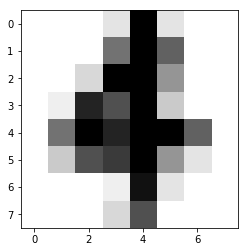

In [2]:
print('Size of training data: {0} x number of features: (pixels) {1}'.format(*arrayOfWrittenDigitImages.shape))
print('Number of ground truth values: {0}'.format(*arrayOfDigitValues.shape))
print()

# let's inspect image 154: 
image_number=154

# we can reshape the image however we like with the following command; here we reshape to 8 x 8 pixels
handWrittenImage = arrayOfWrittenDigitImages[image_number].reshape(8,8)

# let's now view the reshaped image
plt.imshow(handWrittenImage, cmap='Greys')


In [3]:
# now we will print out what we think the ground truth is for this image:
print("Image {0} ground truth value is: '{1}'".format(image_number, 4 ))

# now let's check out what the actual value of the image is
print("Image {0} ground truth value is: '{1}'".format(image_number, arrayOfDigitValues[image_number] ))

# Q: now try writing your own code to inspect some different images in the test set.
# code here...
# code here...

Image 154 ground truth value is: '4'
Image 154 ground truth value is: '4'


### Scale features

Many statistical models work best if all the features are scaled so that their mean and variance are approximately equal. We can do this different ways but the easiest is by subtracting the mean and dividing by the standard deviation also known as **standardisation**.

The features are the pixels. So when we standardise feature number 1 we make the mean of pixel 1 **across all images** to be 0, and its standard deviation to be 1. 


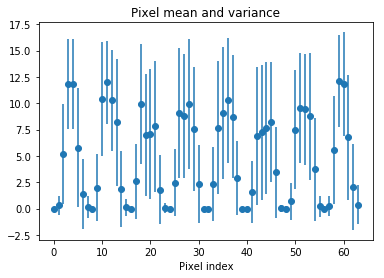

In [4]:
## Now we plot the avg & std deviation of the features prior to any normalization

# for each of the 64 pixels in the image set, get the average & std deviation
arrayOfPixelMeanValues = arrayOfWrittenDigitImages.mean(axis=0)
arrayOfPixelStdDeviations = arrayOfWrittenDigitImages.std(axis=0)

plt.errorbar(range(arrayOfWrittenDigitImages.shape[1]), arrayOfPixelMeanValues,yerr=arrayOfPixelStdDeviations, fmt='o')
plt.title('Pixel mean and variance')
plt.xlabel('Pixel index')

imagesWithPixelsScale: rows = 1797, columns = 64


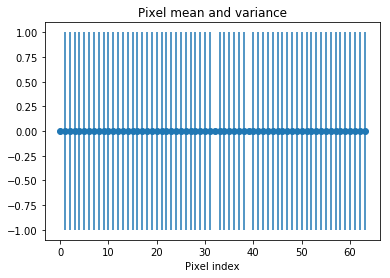

In [7]:
from sklearn import preprocessing

# use the sklearn API to normalize the data in each feature, so that it has a mean = zero, and a std dev = 1
scaler = preprocessing.StandardScaler()
scaler.fit(arrayOfWrittenDigitImages)
imagesWithPixelsScaled = scaler.transform(arrayOfWrittenDigitImages)
print('imagesWithPixelsScale: rows = {0}, columns = {1}'.format(*imagesWithPixelsScaled.shape))

# now we will plot the normalized data
avgOfScaledImages = imagesWithPixelsScaled.mean(axis=0)
stdDevOfScaledImaged = imagesWithPixelsScaled.std(axis=0)

plt.errorbar(range(imagesWithPixelsScaled.shape[1]), avgOfScaledImages,stdDevOfScaledImaged, fmt='o')
plt.title('Pixel mean and variance')
plt.xlabel('Pixel index')

In [66]:
# Q: why do some features/pixels have no standard deviation?

### Reduce dimension
We can use principle component analysis (PCA) to reduce the number of features. To demonstrate the technique we choose to keep only the first 20 components. We can tune this later. See the aside below for more explanation of what PCA is.

#### Aside: principle component analysis

PCA is a way of finding linear combinations of features so that instead of using all the features I use a smaller number of combinanations of features.  

Let's look at a simple example to show you what that means practically. 

Consider a dataset with two features x1 and x2 and with two labels, 1 & 0 (or purple and yellow).  This data is plotted below: 

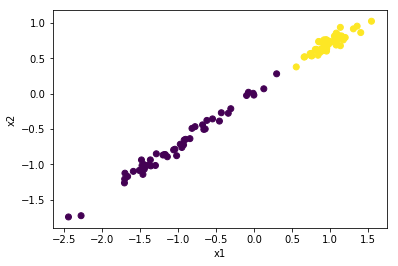

In [71]:
from sklearn.datasets import make_classification
np.random.seed(1)
X, y = make_classification(n_samples=100, n_features=2, n_informative=1, n_redundant=1, n_classes=2, n_clusters_per_class=1, flip_y=0.01)
# (n_samples=100, n_features=20, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)[source]¶
X.T[0] = X.T[0] + np.random.normal(0, .05, X.shape[0])
X.T[1] = X.T[1] + np.random.normal(0, .05, X.shape[0])


plt.scatter(X.T[0], X.T[1], c=y)
plt.ylabel('x2')
plt.xlabel('x1')

How many of the features do we need to classify the two colours?  I could use both coordinates:

##### yellow **if** x1 > 0.4 & x2 > 0.4

##### purple **if** x1 < 0.4 & x2 < 0.4



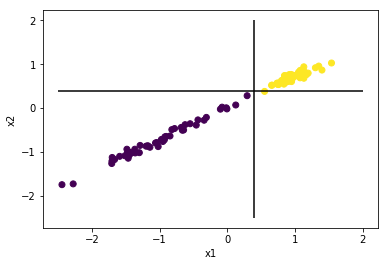

In [92]:
plt.scatter(X.T[0], X.T[1], c=y)
plt.hlines(0.4, -2.5, 2)
plt.vlines(0.4, -2.5, 2)
plt.ylabel('x2')
plt.xlabel('x1')


But we can do better - let's do PCA on the data `X`

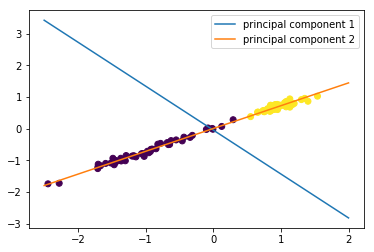

In [93]:
from sklearn.decomposition import PCA

# Calling 'fit' is asking the PCA class to find out a pair of new axes onto which to rotate the
# data such that the data will have the most variance along axis 1, the the least variance along axis 2. 

pca = PCA(n_components=2)
pca.fit(X)
means = pca.mean_

# Plot original data
plt.scatter(X.T[0], X.T[1], c=y)

# Plot the two axes
for i in range(2):
    pc = pca.components_[i,:]

    # Let's plot this as a line
    x1 = np.linspace(-2.5, 2, 5)
    x2 = means[1] - (x1-means[0])*pc[0]/pc[1]
    plt.plot(x1,x2, label='principal component {}'.format(i+1))
plt.legend()


So now we can project the data on these two axes. As you can see the variance in the data is large along principal component 1 and small along principle component 2. Now we only need one feature, the first principal component, to distinguish the two clusters.

##### yellow **if** pc1 < -0.6

##### purple **if** pc1 > -0.6

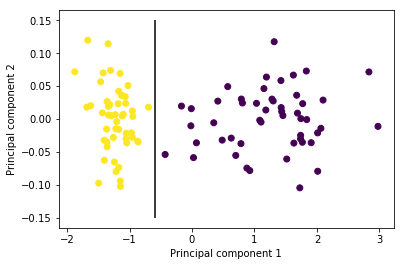

In [95]:
# Now project the data onto thes axes

X_pca = pca.transform(X)
plt.scatter(X_pca.T[0], X_pca.T[1], c=y)
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

# plot the dividing line

plt.vlines(-0.6, -0.15, 0.15)

### Reduce dimension - continued. 
So now we can use this, with arbirtrary numbers of dimensions, to reduce the number of features we need to do our logistic regression


In [96]:
from sklearn import decomposition

# get the first 20 pca components
pca = decomposition.PCA(n_components=20)
pca.fit(imagesWithPixelsScaled)

# using the pca components to transform the images to a lower dimensional representation
image_pca_Representation = pca.transform(imagesWithPixelsScaled)
print(image_pca_Representation.shape)

(1797, 20)


The components of a PCA analysis still have zero mean but their variance has changed. 

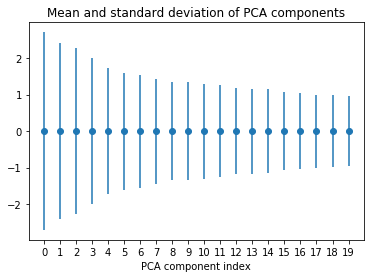

In [101]:
pca_avg = image_pca_Representation.mean(axis=0)
pca_std = image_pca_Representation.std(axis=0)

plt.errorbar(np.arange(image_pca_Representation.shape[1]), pca_avg , yerr=pca_std, fmt='o')
plt.title('Mean and standard deviation of PCA components')
plt.xticks(np.arange(image_pca_Representation.shape[1]))
plt.xlabel('PCA component index')

The PCA components are ordered in terms of their ability to explain the variance in the data. 

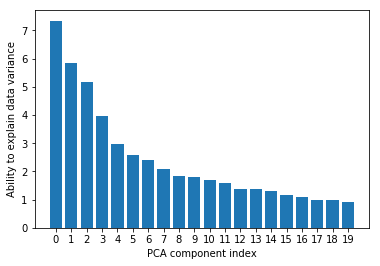

In [102]:
# now we will plot the pca components, ordered in terms of their "explanatory power" - i.e., 
#   their ability to explain variance in the data

plt.bar(np.arange(pca.n_components_), pca.explained_variance_)
plt.xticks(np.arange(pca.n_components_))
plt.ylabel('Ability to explain data variance')
plt.xlabel('PCA component index')

### Fit model 
Now we can apply an estimator to the data to try and make predictions. We're going to use a [Logistic Regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) classifier. 

This model tries to find parameters for a multinomial logistic classifier that minimize the cost function.  The cost function is complicated for multinomial classification but you can read about it [here](https://en.wikipedia.org/wiki/Multiclass_classification#One-vs.-rest).  It essentially penalizes incorrect predictions, so minimizing the cost results in fewer incorrect predictions. 


The parameter we will tune later is `C`, the regularization strength (actually the inverse of the regularization strenth).  Regularization adds a term to the cost function which means smaller parameter values are favoured over larger ones. The effect of this is make some features unimportant as they end up getting multiplied by parameters close to zero.  The reason this is done is to avoid overfitting the model to the data - i.e. to improve transferability. 



In [105]:
from sklearn import linear_model

# specify logistic regression with a specified regularization
logistic = linear_model.LogisticRegression(C=0.001)

# fit a logistic regression mapping function which can transfer image_pcaRepresentation to arrayOfDigitValues
logistic.fit(image_pca_Representation, arrayOfDigitValues)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [106]:
# now let's look at the classification accuracy of our logistic regression mapping function
score = logistic.score(image_pca_Representation, arrayOfDigitValues)
print('Mean accuracy = {:4.2f}%'.format(100*score))

Mean accuracy = 88.76%


## Pipelines and hyperparameter optimization

Our first attempt resulted in pretty poor accuracy, but we haven't fully explored the hyperparameter space, so maybe we can do better. 

To speed up optimisation of these parameters, we can combine all the step we took above into a single pipeline. Then we can split the data into test and training data to more accurately test the model's accuracy. 

The training data can be further split into training and validation to optimize the hyperparameters, or (better) use cross validation on the training data to optimize the hyperparameters. 

The hyperparameters to be explored are the number of PCA components and the logistic regression regularization strength. 

The training/test split will be 60/40.  On the training data will we use 5-fold cross validation with a grid-search parameter optimization.  

### Split data: train/test

First split the data into training and test data. `X_train` and `X_test` are the features (the pixels) for the training and test data, and `y_train` and `y_test` are the targets.

In [107]:
from sklearn.model_selection import train_test_split

trainingImages, testingImages, trainingValues, testingValues = train_test_split(
    arrayOfWrittenDigitImages, arrayOfDigitValues, test_size=0.4, random_state=0)

print(trainingImages.shape, testingImages.shape)
print(trainingValues.shape, testingValues.shape)

(1078, 64) (719, 64)
(1078,) (719,)


### Setup pipeline
See [Pipelines](http://scikit-learn.org/stable/modules/pipeline.html#pipeline-chaining-estimators).  We chain all the steps for scaling, dimensionality reduction and fitting together in a pipeline. We **don't** set any hyperparameters that we want to optimize using cross validation.  Although if there are parameters that don't change we could set them here. See the docs for instructions. 

In [108]:
from sklearn.pipeline import Pipeline

scaler = preprocessing.StandardScaler()
pca = decomposition.PCA()
logistic = linear_model.LogisticRegression()

# Now we set up a machine learning "pipeline" 
# which is essentially a list of the steps we want to take to prepare our data & train our model

pipe = Pipeline(steps=[('scale', scaler), ('pca', pca), ('logistic', logistic)])

### Setup parameter search

We will use a grid search strategy to go through all the possible values of the hyperparameters and record the score of
prediction.  For each combination of hyperparameters, the model will be fit on 4/5ths of the training data and then scored
on the remaining 1/5th.  This is repeated 5 times by changing the 1/5th of the training data that is left out. See the [cross validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) for more information. 

This strategy allows you to get an average accuracy and error for each set of hyperparameters.  

In [112]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# 5-fold cross validation.  
# This is an iterator that will split up the data into two groups of size 4/5 and 1/5 of the training data
cv_iter = KFold(n_splits=5)
# Print out the size of the train / test data for each group.
ctr = 1
for train, test in cv_iter.split(trainingImages):
    print("cross validation group %s: %s training images and %s test images" % (ctr, train.shape[0], test.shape[0]))
    ctr = ctr + 1
print("\n")
    
# specify & print the range of PCA components that we'll explore.
n_components = list(np.arange(20, 65, 4))
print("PCA components to explore:")
print(n_components,"\n")

# specify & print the range of regularization values that we'll explore.
Cs = np.logspace(-4, 4, 10)
print("Regularization values to explore:")
print(Cs)

# Set up the Grid Search Estimator, includes:
#   - the pipeline specification
#   - the parameters over which we will carry out grid search
#   - the training/test data for each cross validation group
estimator = GridSearchCV(pipe,dict(pca__n_components=n_components,logistic__C=Cs), cv=cv_iter)

cross validation group 1: 862 training images and 216 test images
cross validation group 2: 862 training images and 216 test images
cross validation group 3: 862 training images and 216 test images
cross validation group 4: 863 training images and 215 test images
cross validation group 5: 863 training images and 215 test images


PCA components to explore:
[20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64] 

Regularization values to explore:
[  1.00000000e-04   7.74263683e-04   5.99484250e-03   4.64158883e-02
   3.59381366e-01   2.78255940e+00   2.15443469e+01   1.66810054e+02
   1.29154967e+03   1.00000000e+04]


## Find optimal estimator

Now we fit the `estimator` just like we would any other model, but now it's doing a fit for each pair of values in the grid search

In [113]:
estimator.fit(trainingImages, trainingValues)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_i...y='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'logistic__C': array([  1.00000e-04,   7.74264e-04,   5.99484e-03,   4.64159e-02,
         3.59381e-01,   2.78256e+00,   2.15443e+01,   1.66810e+02,
         1.29155e+03,   1.00000e+04]), 'pca__n_components': [20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

The best scoring model is saved in the estimator object. Let's print it out to see which one was the best.

In [16]:
print(estimator.best_estimator_)

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=48, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=2.7825594022071258, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])


In [17]:
# Q : use the sklearn API to access the 1) best score and 2) the dictionary of best parameters

print('Best accuracy {:4.2f}% '.format(100*estimator.best_score_))
print('was achieved with: \n{}'.format(estimator.best_params_))

Best accuracy 96.10% 
was achieved with: 
{'logistic__C': 2.7825594022071258, 'pca__n_components': 48}


We can now test the model on the full test data for a better reflection of it's accuracy

In [18]:
# Q now test the estimator on the test data for the final assessment of the model

test_score = estimator.score(testingImages,testingValues)
print('Score on test data: {:4.2f}%'.format(test_score*100))

Score on test data: 95.69%


### Understanding the effect of the hyperparameters

The scores from all the different sets of parameters was recorded in the estimator object and can be converted to a dataframe. 


In [19]:
import pandas as pd
results = pd.DataFrame(estimator.cv_results_)
results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_logistic__C,param_pca__n_components,params,rank_test_score,split0_test_score,split0_train_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.016984,0.000789,0.833952,0.848565,0.0001,20,"{u'logistic__C': 0.0001, u'pca__n_components':...",120,0.805556,0.858469,...,0.856481,0.853828,0.823256,0.848204,0.823256,0.837775,0.005617,0.000235,0.021371,0.007190
1,0.014017,0.000566,0.844156,0.854129,0.0001,24,"{u'logistic__C': 0.0001, u'pca__n_components':...",119,0.824074,0.857309,...,0.865741,0.859629,0.841860,0.858633,0.823256,0.844728,0.001491,0.000084,0.018860,0.005715
2,0.017261,0.000589,0.849722,0.856681,0.0001,28,"{u'logistic__C': 0.0001, u'pca__n_components':...",118,0.837963,0.863109,...,0.865741,0.863109,0.846512,0.859791,0.827907,0.847045,0.001994,0.000095,0.016172,0.006712
3,0.016534,0.000545,0.858071,0.862014,0.0001,32,"{u'logistic__C': 0.0001, u'pca__n_components':...",115,0.856481,0.866589,...,0.870370,0.868910,0.851163,0.864426,0.827907,0.853998,0.001060,0.000019,0.018953,0.005882
4,0.018282,0.000621,0.858071,0.863869,0.0001,36,"{u'logistic__C': 0.0001, u'pca__n_components':...",115,0.842593,0.868910,...,0.875000,0.871230,0.851163,0.866744,0.832558,0.858633,0.001639,0.000134,0.020858,0.006574


We can plot the results on a seaborn facetgrid to understand how the different hyperparameters affect the accuracy of the prediction. Recall that we've split the data two different ways. 
1. 60/40 split for training and **final** test. We will ignore this test data from now on. 
2. 5-fold cross validation on the training data. i.e. 80/20 split.  The 80/20 split is still referred to as a training/test split in the results below. 

We'd like to see (for didactic purposes) the score on the training/test data from the cross validation results. We would expect the test data to score worse than the training data. To do this we need to melt the data frame so that the training/test scores are in the same column. This is slightly complicated but I'm putting it here to show you the power of dataframes. 

In [20]:
# First subset the dataframe so that it only gives the results we're interested in. 
df = results.copy()
df.set_index(['param_logistic__C', 'param_pca__n_components'], inplace=True)
df = df.filter(regex=("mean.*score$|std.*score$"))
df.head()

mean_test_score  mean_train_score  \
param_logistic__C param_pca__n_components                                      
0.0001            20                              0.833952          0.848565   
                  24                              0.844156          0.854129   
                  28                              0.849722          0.856681   
                  32                              0.858071          0.862014   
                  36                              0.858071          0.863869   

                                           std_test_score  std_train_score  
param_logistic__C param_pca__n_components                                   
0.0001            20                             0.021371         0.007190  
                  24                             0.018860         0.005715  
                  28                             0.016172         0.006712  
                  32                             0.018953         0.005882  
                  36                             0.020858         0.006574

In [21]:
# Now create a multi-index on the columns. 
df.columns = df.columns.str.replace('_score', '')
df.columns = pd.MultiIndex.from_tuples(tuple(df.columns.str.split("_")))
df.head()


mean                 std  \
                                               test     train      test   
param_logistic__C param_pca__n_components                                 
0.0001            20                       0.833952  0.848565  0.021371   
                  24                       0.844156  0.854129  0.018860   
                  28                       0.849722  0.856681  0.016172   
                  32                       0.858071  0.862014  0.018953   
                  36                       0.858071  0.863869  0.020858   

                                                     
                                              train  
param_logistic__C param_pca__n_components            
0.0001            20                       0.007190  
                  24                       0.005715  
                  28                       0.006712  
                  32                       0.005882  
                  36                       0.006574

In [22]:
# Now collapse the columns and rename the columns
df = df.stack(level = 1).reset_index()
df.rename(columns={'level_2':'CV_split', 'mean':'accuracy', 'std':'error', 
                  'param_logistic__C': 'regularization_C', 'param_pca__n_components':'PCA_components'}, inplace=True)

In [23]:
df.head()

,regularization_C,PCA_components,CV_split,accuracy,error
0,0.0001,20,test,0.833952,0.021371
1,0.0001,20,train,0.848565,0.007190
2,0.0001,24,test,0.844156,0.018860
3,0.0001,24,train,0.854129,0.005715
4,0.0001,28,test,0.849722,0.016172


Now we can see the effect of changing the hyperparameters on the accuracy.  For each change the test score is worse than the training score (as expected).

In [24]:
import seaborn as sns
with sns.plotting_context('notebook', font_scale=1.5):
    grid = sns.FacetGrid(df, col='regularization_C', hue='CV_split', col_wrap=5, legend_out=True)
    grid.map(plt.errorbar, "PCA_components", "accuracy", "error")
    grid.set_titles('C: {col_name:4.2e}')
    grid.set_xlabels('PCA components')
    grid.set_ylabels('Test score')
    for ax in grid.axes:
        ax.legend()
plt.tight_layout()
plt.show()

ImportError: No module named seaborn